In [1]:
#imports
#input
import matplotlib.pyplot as plt
import skimage
from skimage import io
from glob import glob

#image represenation
import numpy as np
from numpy import ma
import pandas as pd 

#image processing
from skimage import measure, filters, morphology, feature,segmentation, draw
from skimage.morphology import disk, square

#plotting
import seaborn as sns
import tabulate


In [2]:
radrat = 1

./tchakamau/Scans_of_balls\FG-w1x-01.21_001.csv ./tchakamau/Scans_of_balls\FG-w1x-01.21-_001_C.tif
./tchakamau/Scans_of_balls\FG-w1x-01.21_002.csv ./tchakamau/Scans_of_balls\FG-w1x-01.21-_002_C.tif
./tchakamau/Scans_of_balls\FG-w1x-01.21_003.csv ./tchakamau/Scans_of_balls\FG-w1x-01.21-_003_C.tif
./tchakamau/Scans_of_balls\FG-w1x-01.21_004.csv ./tchakamau/Scans_of_balls\FG-w1x-01.21-_004_C.tif
./tchakamau/Scans_of_balls\FG-w1x-01.21_005.csv ./tchakamau/Scans_of_balls\FG-w1x-01.21-_005_C.tif
./tchakamau/Scans_of_balls\FG-w1x-01.21_006.csv ./tchakamau/Scans_of_balls\FG-w1x-01.21-_006_C.tif
./tchakamau/Scans_of_balls\FG-w1x-01.21_007.csv ./tchakamau/Scans_of_balls\FG-w1x-01.21-_007_C.tif
./tchakamau/Scans_of_balls\FG-w1x-01.21_008.csv ./tchakamau/Scans_of_balls\FG-w1x-01.21-_008_C.tif
[            1           2           3           4           5           6     \
0     324.586639  324.215242  337.671239  327.286409  322.472533  334.485796   
1     334.128684  332.614527  333.128769  340.6

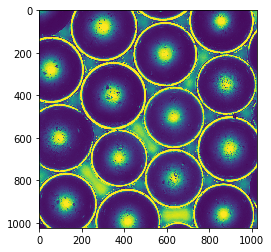

In [3]:
filenames = glob('./tchakamau/Scans_of_balls/FG-w*.csv')
filenames2 = glob('./tchakamau/Scans_of_balls/FG*_*[1-9]*_C.tif')
[print(i, z) for i,z in zip(filenames, filenames2)]
tables = [pd.read_csv(filename, skiprows=19, header = None).iloc[:, 1:-1] for filename in filenames]
intensities = [io.imread(filename2, as_gray=True) for filename2 in filenames2]

print(tables, len(tables))
plt.imshow(intensities[1])

In [4]:
def vector_dist(a, b):
    sqdist = 0
    if len(a)==len(b):
        for x, y in zip(a, b):
            square = (x-y)*(x-y)
            sqdist += square
        return np.abs(np.around(np.sqrt(sqdist), 6))
    else:
        print("Error in distances")
        
print(vector_dist((0,3), (4, 0)))

def curve_heights(distance,radius):
    if distance <= radius:
        angle = np.arcsin(distance / radius)
        height = radius * np.cos(angle)
        return np.around(height, 6)
    else:
        print(distance, radius, "Could not compute angle")
    
print(curve_heights(0, 5), curve_heights(10, 10))

5.0
5.0 0.0


[[0.08380431 0.08968314 0.08407216 ... 0.07341569 0.0683702  0.07343059]
 [0.08573882 0.08573882 0.0865949  ... 0.08351373 0.08241255 0.08383412]
 [0.07846118 0.07817843 0.07537294 ... 0.08548588 0.08913961 0.09922275]
 ...
 [0.05716392 0.05743176 0.06865373 ... 0.50013843 0.46292392 0.43350157]
 [0.0650149  0.0675149  0.07172706 ... 0.47686196 0.3862451  0.42611804]
 [0.0650149  0.07256039 0.06837098 ... 0.48053922 0.41715961 0.4730149 ]] 1024


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

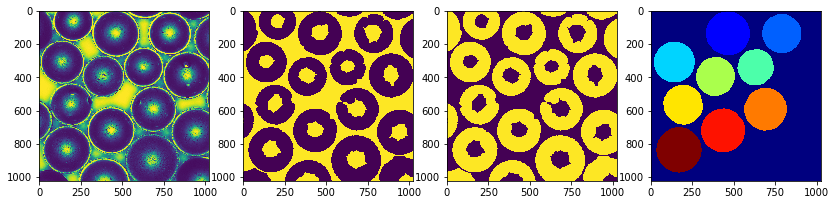

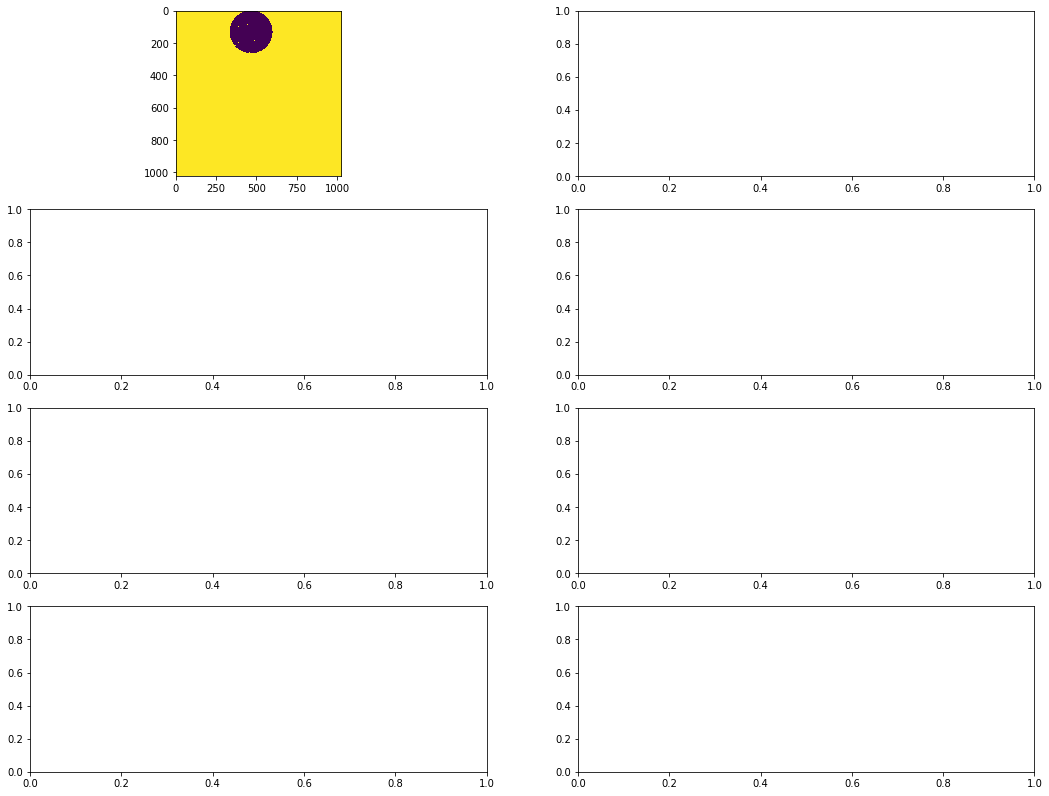

In [17]:
wroughs = []
wmeans = []

for table, intensity in zip(tables[3:4], intensities[3:4]):
    intense = np.ascontiguousarray(np.fliplr(np.rot90(intensity, k=3)))
    image = np.array(table, copy=True)
    fig, ax = plt.subplots(ncols=4,figsize=(14, 10))
    ax[0].imshow(intense)
    print(intense, len(intense))
       
    bw_balls = intense  > filters.threshold_isodata(intense)
    inverse = morphology.closing(bw_balls, disk(20))
    filled_balls =np.invert(inverse)#morphology.convex_hull_object(morphology.remove_small_objects(bw_balls, min_size=2000))
    inner_balls = segmentation.clear_border(filled_balls)
    labeled_balls = measure.label(morphology.convex_hull_object(inner_balls))
    
    ax[1].imshow(inverse)
    ax[2].imshow(filled_balls)#(filled_balls)
    ax[3].imshow(labeled_balls, cmap='jet')
    
    # collect radii in a list
    regions = measure.regionprops(labeled_balls)
    regions = regions[0:2]
    centers = [x.centroid for x in regions]
    radii = [x.equivalent_diameter/2 for x in regions]
    piece_radii = [x/radrat for x in radii] # use 1/radrat of a radius
    
    ##Plot image of the circular region for each ball collected, varying in intensity 
    #make function that takes centers and circles and makes the map
    #by making the circles and setting them to 1
    fig, ax = plt.subplots(nrows = 4, ncols = len(regions), figsize=(18, 14))
    ind = 0
    #blank = np.zeros_like(image)
    for center, radius in zip(centers, piece_radii): # per ball
        coords = draw.circle(center[0], center[1], radius)
        blank = np.zeros_like(image)
        circle = np.ones_like(image)
        circle[coords] = 0
        circle[image > 420] = 1
        #print(len(coords))
        #print(list(coords))
        
        #Set heights of circle mask 
        for row, column in zip(coords[0], coords[1]):
            #print(row, column)
            #print(center)
            distance= vector_dist((row, column), center)
            #print(distance)      
            curve_height = curve_heights(distance, radius)
            blank[(row, column)] = curve_height #set the heights of the mask
        
        ax[0][ind].imshow(circle)
        ball_cap = ma.masked_array(image, circle)
        trace = ball_cap[center[0]]
        ax[1][ind].imshow(trace)
        image = image - blank
        ball_cap = ma.masked_array(image, circle)
        trace = ball_cap[center[0]]
        ax[2][ind].imshow(trace)
        roughness = np.std(ball_cap)
        mean = np.mean(ball_cap)
        wroughs.append(roughness)
        wmeans.append(mean)
        #ax[2][ind].imshow(blank)
        ax[3][ind].imshow(ball_cap)
        #ax[4][ind].hist(ball_cap)
        ind += 1
"""     #collect image from circle mask
        circle = np.ones_like(image)
        circle[coords] = 0
        ball_cap = ma.masked_array(image, circle)
        roughness = np.var(ball_cap)
        mean = np.mean(ball_cap)
        wroughs.append(roughness)
        wmeans.append(mean)
        ax[0][ind].imshow(ball_cap)
        ax[1][ind].imshow(normal_cap)
        ind +=1
    #show subtraction fo that fom the cap as wll a the cap
    
    
    for radius, center in zip(radii, centers):
        circle = np.ones_like(image)
        coords=draw.circle(center[0], center[1], radius)
        circle[coords]=0
        ball_cap = ma.masked_array(image, circle)
        roughness = np.var(ball_cap)
        mean = np.mean(ball_cap)
        wroughs.append(roughness)
        wmeans.append(mean)
        ax[ind].imshow(ball_cap)
        ind +=1
        """
        

[48.25260005452635, 53.19579810155155, 43.84889674642717, 45.12623130975118, 50.29704390053389, 45.08801172883971, 43.91163666643047, 50.30863594929811, 46.61958784704493, 50.790522331844144, 51.22951819297634, 48.05731126746509, 43.911725432237496, 43.622721048633714, 41.89468643123243, 40.243736338970784, 40.38205992414437, 42.06484159712974, 38.42924955115934, 35.11235215928774, 37.072855174756164, 45.912433009546824, 45.71414202926057, 43.79281869010987, 52.68514183288276, 42.71029997767924, 45.12745470898265, 40.49486369345123, 45.852245966290056, 45.35749986586577, 38.059291829379006, 39.758480893552466, 37.698139154600796, 46.41494379289751, 43.70073505843171, 44.51585613440606, 44.582787826949215, 51.307155005738295, 45.32961782166636, 43.73024863503687, 39.928188885214226, 37.62087588784651, 36.96703021261498, 42.980211339777114, 42.18665895764831, 34.79451872316981, 40.6094890499559, 40.82092952311559, 35.30927166755731, 41.673932442254184, 44.786278180479385, 42.952627635534

Text(0.5, 0, "Mean value - 'Intensity'")

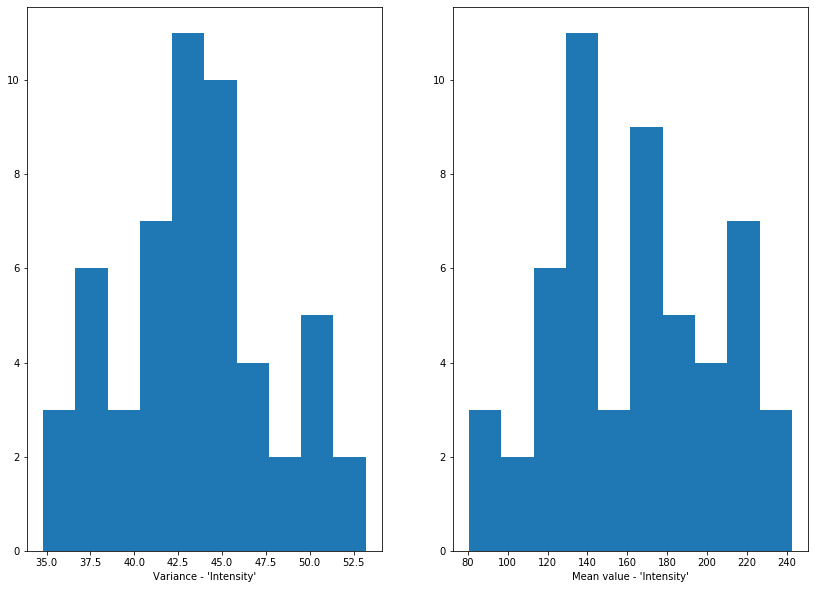

In [6]:
#Label, get_center, take from each center point, a radius of half the actual radius of that region, mask the array to exclude the rest
# for that blob, then get the average deviation of intensity for each of the remaining blob surfaces.
print(wroughs, len(wroughs))
fig, ax = plt.subplots(ncols=2, figsize=(14,10))
ax[0].hist(wroughs)
ax[0].set_xlabel("Variance - 'Intensity'")
ax[1].hist(wmeans)
ax[1].set_xlabel("Mean value - 'Intensity'")

./tchakamau/Scans_of_balls\FG-S-w0x-01.17_001.csv ./tchakamau/Scans_of_balls\G_001_C.tif
./tchakamau/Scans_of_balls\FG-S-w0x-01.17_002.csv ./tchakamau/Scans_of_balls\G_002_C.tif
./tchakamau/Scans_of_balls\FG-S-w0x-01.17_003.csv ./tchakamau/Scans_of_balls\G_003_C.tif
./tchakamau/Scans_of_balls\FG-S-w0x-01.17_004.csv ./tchakamau/Scans_of_balls\G_004_C.tif
./tchakamau/Scans_of_balls\FG-S-w0x-01.17_005.csv ./tchakamau/Scans_of_balls\G_005_C.tif
./tchakamau/Scans_of_balls\FG-S-w0x-01.17_006.csv ./tchakamau/Scans_of_balls\G_006_C.tif
./tchakamau/Scans_of_balls\FG-S-w0x-01.17_007.csv ./tchakamau/Scans_of_balls\G_007_C.tif
./tchakamau/Scans_of_balls\FG-S-w0x-01.17_008.csv ./tchakamau/Scans_of_balls\G_008_C.tif
./tchakamau/Scans_of_balls\FG-S-w0x-01.17_009.csv ./tchakamau/Scans_of_balls\G_009_C.tif
./tchakamau/Scans_of_balls\FG-S-w0x-01.17_010.csv ./tchakamau/Scans_of_balls\G_010_C.tif
[            1           2          3           4           5          6     \
0      67.369776   74.643921  4

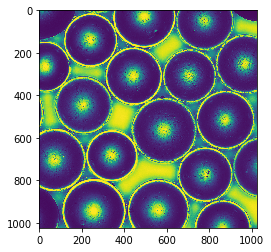

In [7]:
filenames = glob('./tchakamau/Scans_of_balls/FG-S*.csv')
filenames2 = glob('./tchakamau/Scans_of_balls/G*_*[1-9]*_C.tif')
[print(i, z) for i,z in zip(filenames, filenames2)]
tables = [pd.read_csv(filename, skiprows=19, header = None).iloc[:, 1:-1] for filename in filenames]
intensities = [io.imread(filename2, as_gray=True) for filename2 in filenames2]

print(tables, len(tables))
plt.imshow(intensities[1])

[[0.01819412 0.02220431 0.12862078 ... 0.04230392 0.03585961 0.03502627]
 [0.01959294 0.04070392 0.14456784 ... 0.04398549 0.04512431 0.03951333]
 [0.0218251  0.04795882 0.19536431 ... 0.04174549 0.04400039 0.04625529]
 ...
 [0.13866863 0.12021451 0.12159843 ... 0.4085498  0.37856039 0.4082302 ]
 [0.10728824 0.10842706 0.10649255 ... 0.4015102  0.40036353 0.41989686]
 [0.11432863 0.11962627 0.17875608 ... 0.40265686 0.40709137 0.41721216]] 1024
[[0.63608196 0.65997725 0.63296745 ... 0.0775902  0.08599882 0.11426118]
 [0.58549451 0.60706745 0.62392039 ... 0.0890949  0.10677608 0.08545608]
 [0.56930392 0.47336039 0.42409137 ... 0.09665529 0.09021098 0.07506745]
 ...
 [0.02745098 0.02606706 0.02829922 ... 0.56045882 0.50018157 0.41351765]
 [0.02745098 0.02773373 0.03053922 ... 0.52060863 0.42473176 0.44017451]
 [0.02773373 0.03053922 0.02773373 ... 0.56938824 0.5124451  0.54692314]] 1024
[[0.16117137 0.15497294 0.13955451 ... 0.94455451 0.94233725 0.94012784]
 [0.17572667 0.16581412 0.160

IndexError: index 1024 is out of bounds for axis 0 with size 1024

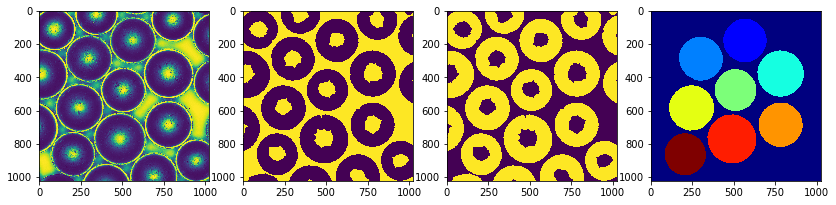

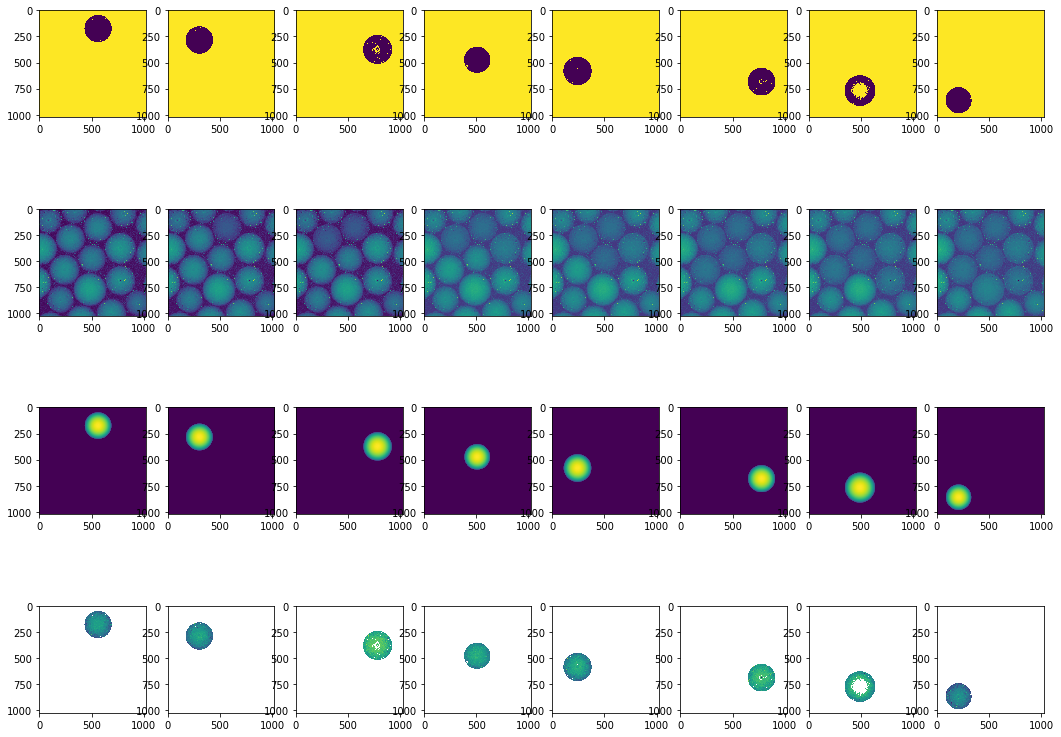

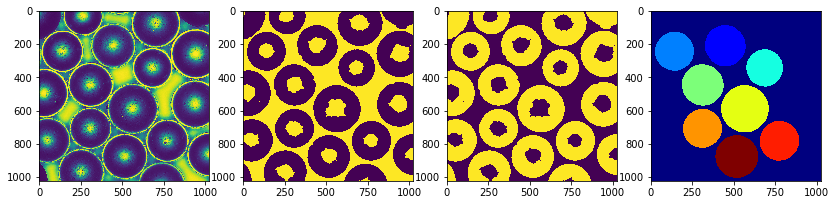

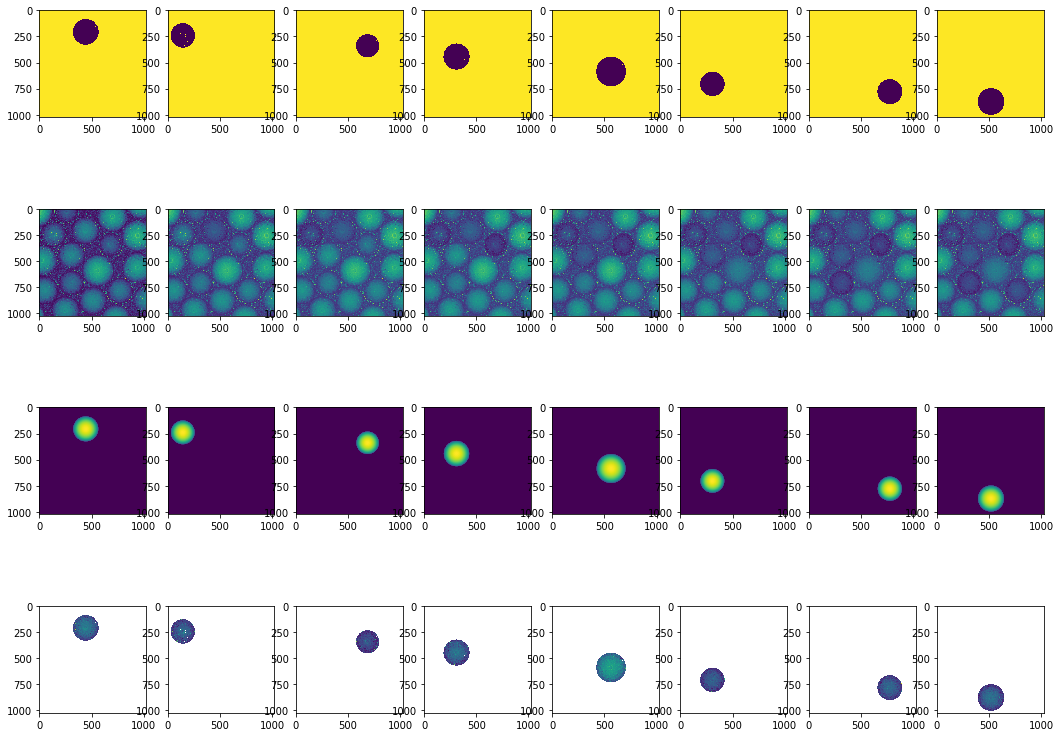

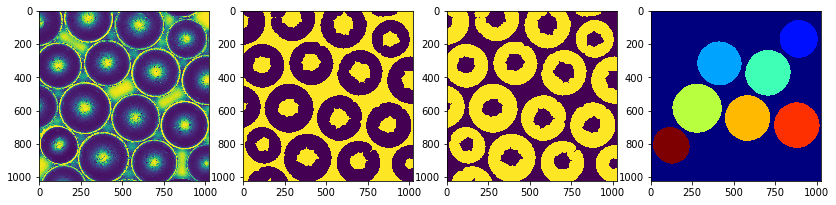

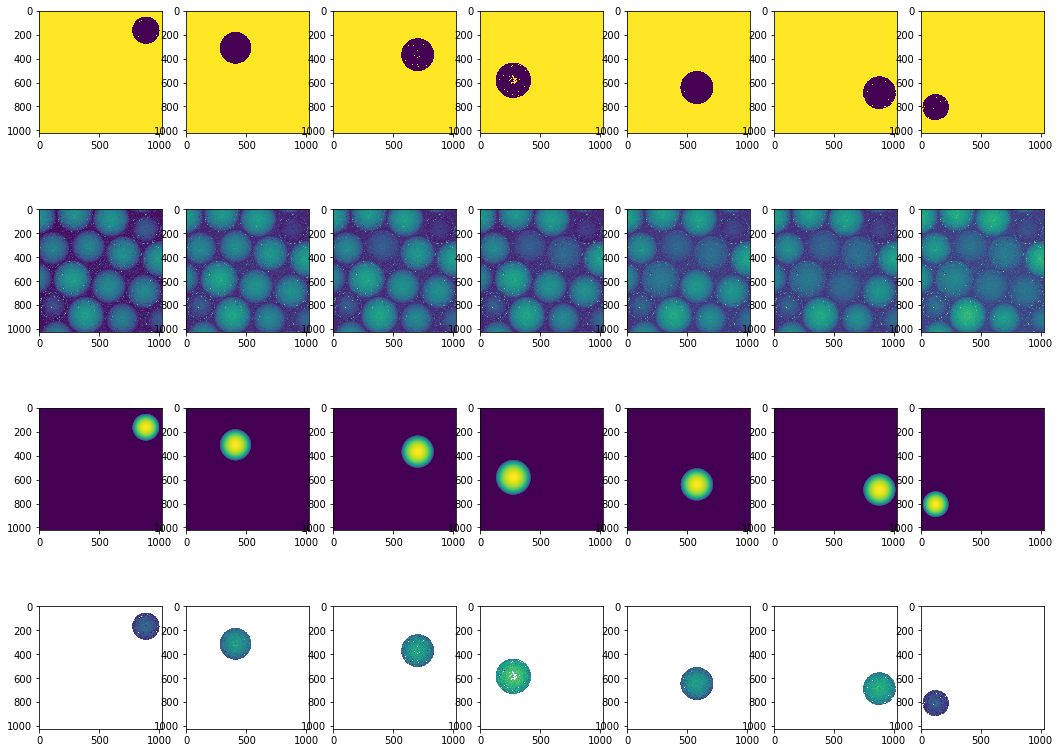

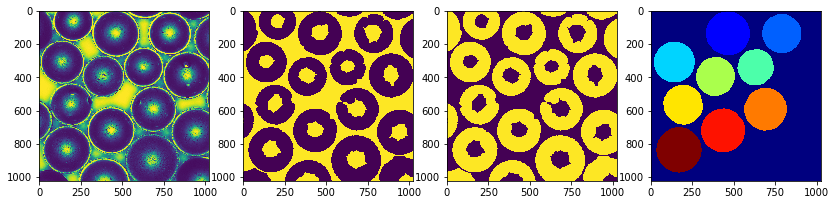

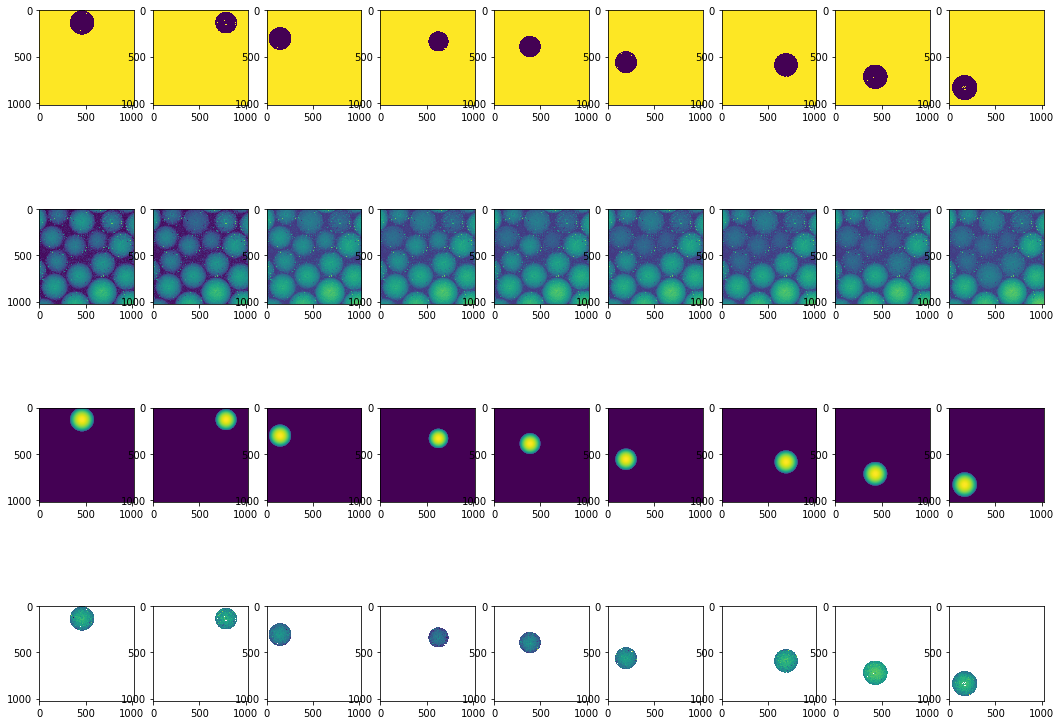

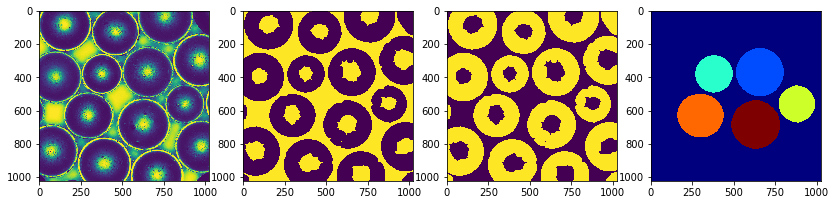

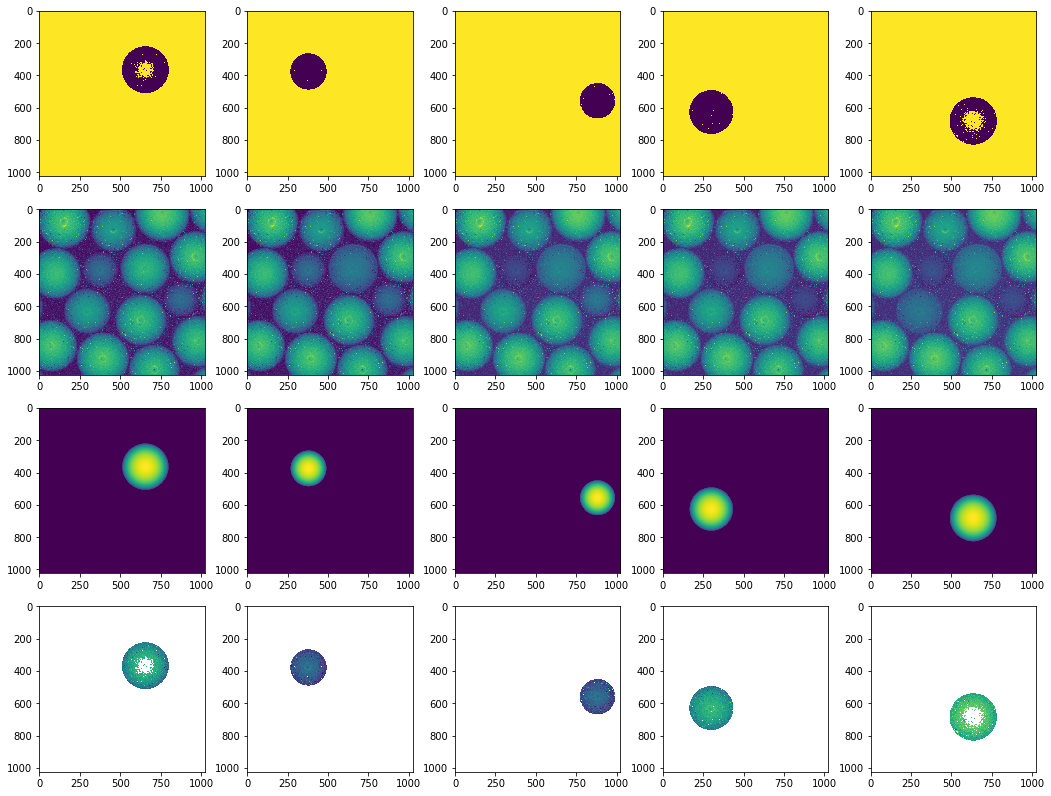

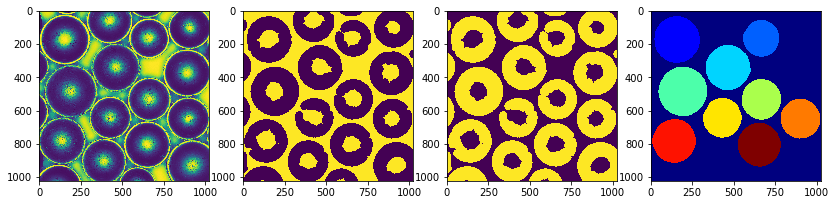

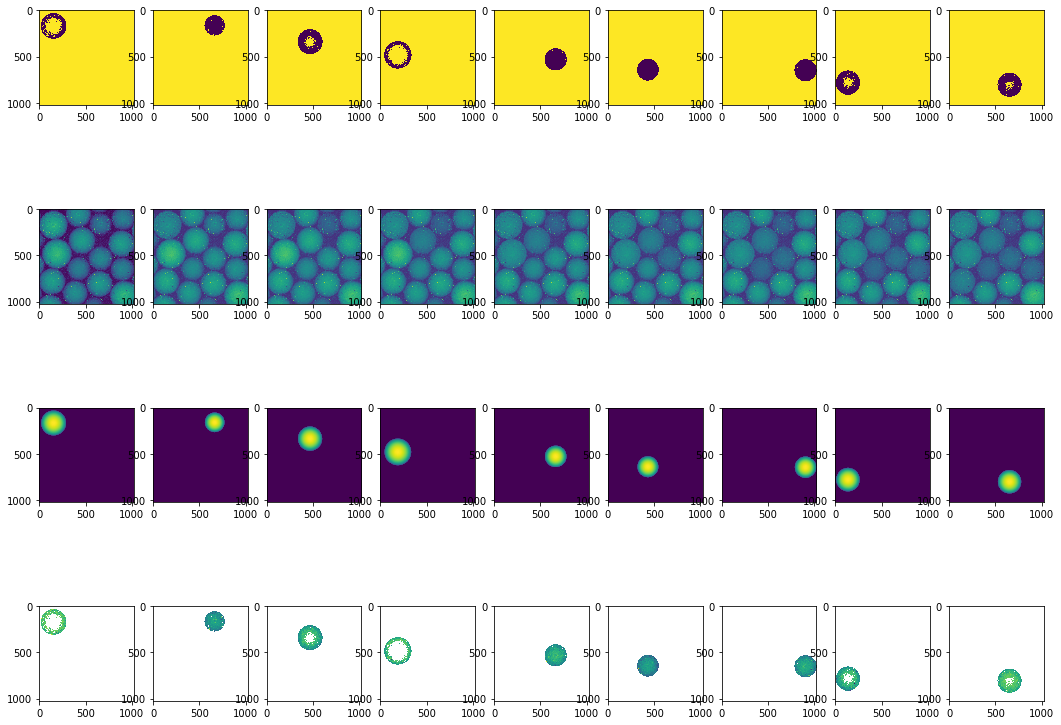

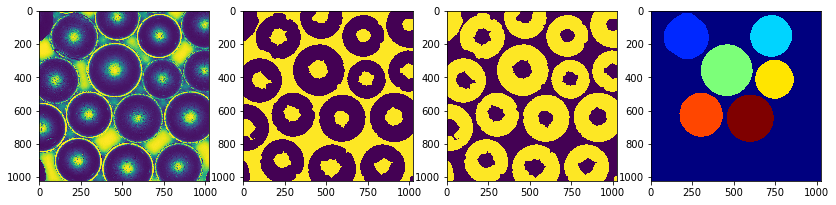

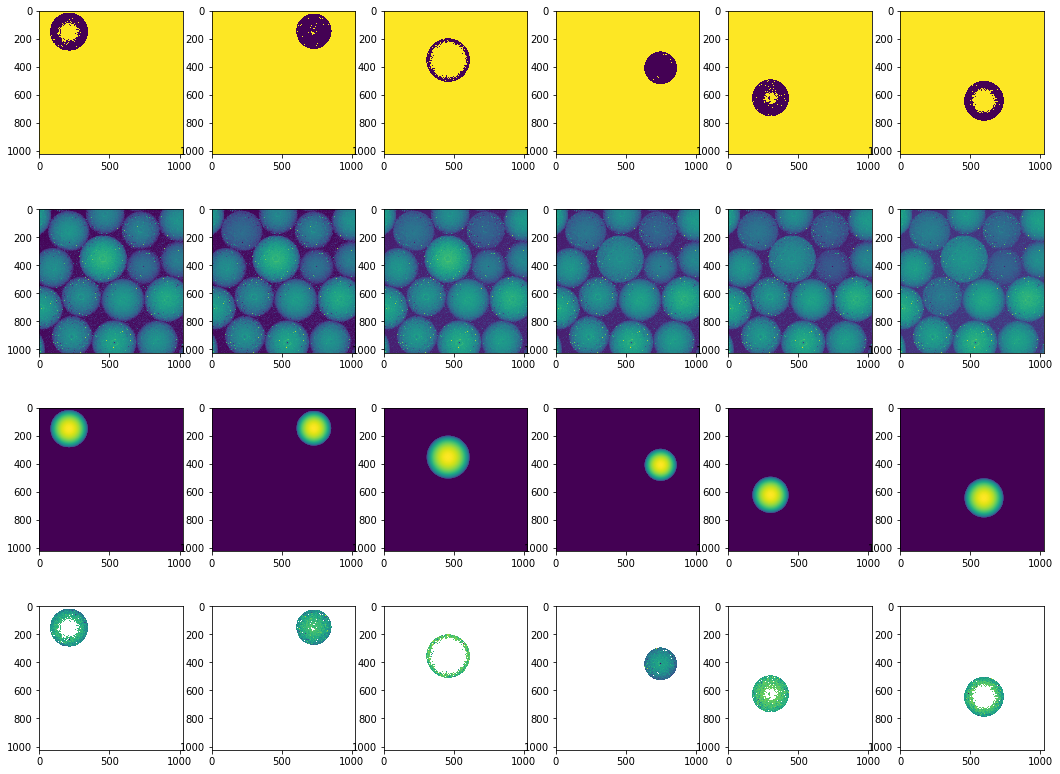

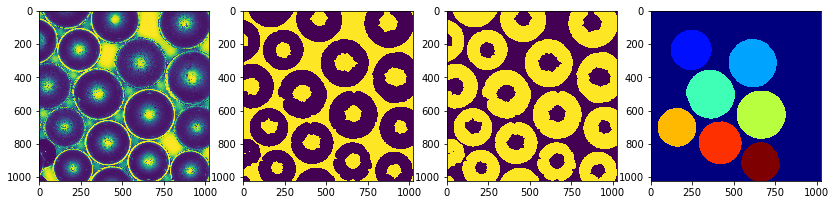

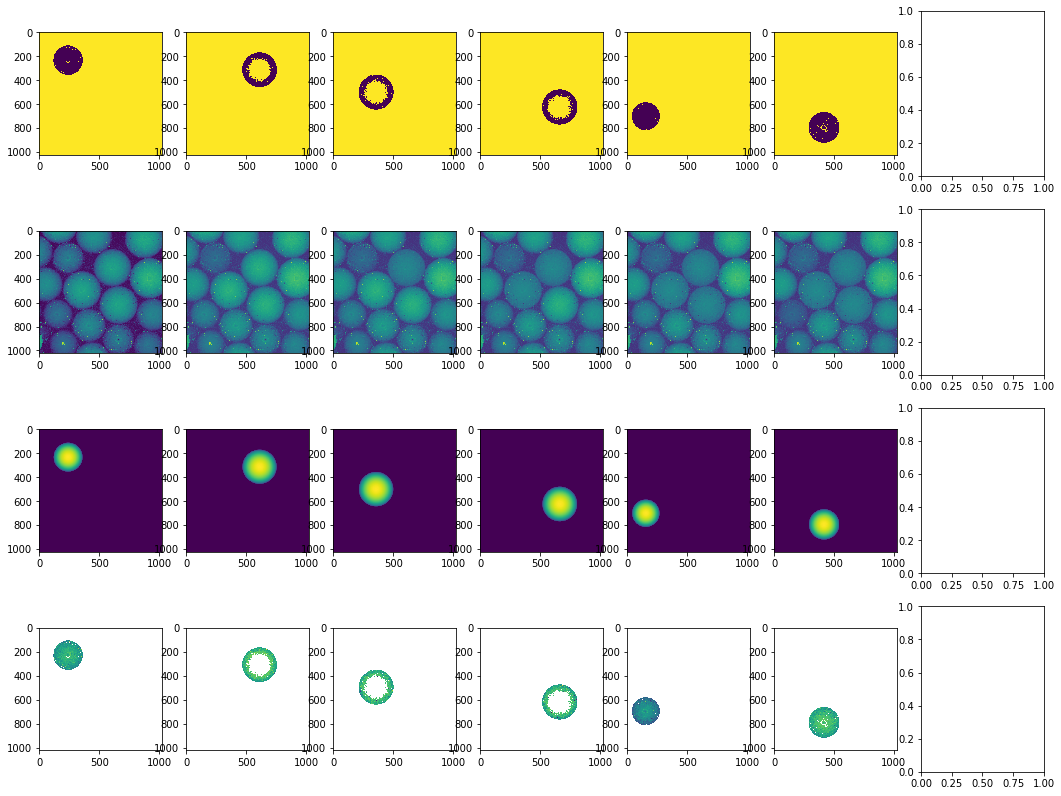

In [8]:
roughs = []
means = []

for table, intensity in zip(tables, intensities):
    intense = np.ascontiguousarray(np.fliplr(np.rot90(intensity, k=3)))
    image = np.array(table, copy=True)
    fig, ax = plt.subplots(ncols=4,figsize=(14, 10))
    ax[0].imshow(intense)
    print(intense, len(intense))
       
    bw_balls = intense  > filters.threshold_isodata(intense)
    inverse = morphology.closing(bw_balls, disk(20))
    filled_balls =np.invert(inverse)#morphology.convex_hull_object(morphology.remove_small_objects(bw_balls, min_size=2000))
    inner_balls = segmentation.clear_border(filled_balls)
    labeled_balls = measure.label(morphology.convex_hull_object(inner_balls))
    
    ax[1].imshow(inverse)
    ax[2].imshow(filled_balls)#(filled_balls)
    ax[3].imshow(labeled_balls, cmap='jet')
    
    # collect radii in a list
    regions = measure.regionprops(labeled_balls)
    centers = [x.centroid for x in regions]
    radii = [x.equivalent_diameter/2 for x in regions]
    piece_radii = [x/radrat for x in radii] # use 1/radrat of a radius
    
    ##Plot image of the circular region for each ball collected, varying in intensity 
    #make function that takes centers and circles and makes the map
    #by making the circles and setting them to 1
    fig, ax = plt.subplots(nrows = 4, ncols = len(regions), figsize=(18, 14))
    ind = 0
    #blank = np.zeros_like(image)
    for center, radius in zip(centers, radii): # per ball
        coords = draw.circle(center[0], center[1], radius)
        blank = np.zeros_like(image)
        circle = np.ones_like(image)
        circle[coords] = 0
        circle[image > 390] = 1
        #print(len(coords))
        #print(list(coords))
        
        #Set heights of circle mask 
        for row, column in zip(coords[0], coords[1]):
            #print(row, column)
            #print(center)
            distance= vector_dist((row, column), center)
            #print(distance)      
            curve_height = curve_heights(distance, radius)
            blank[(row, column)] = curve_height #set the heights of the mask
        
        ax[0][ind].imshow(circle)
        ax[1][ind].imshow(image)
        image = image - blank
        #ax[2][ind].imshow(image)
        ball_cap = ma.masked_array(image, circle)
        roughness = np.std(ball_cap)
        mean = np.mean(ball_cap)
        roughs.append(roughness)
        means.append(mean)
        ax[2][ind].imshow(blank)
        ax[3][ind].imshow(ball_cap)
        #ax[4][ind].hist(ball_cap)
        ind += 1

[36.079263477477525, 36.12762106167058, 37.770502001505555, 35.43329163888915, 36.412768965563984, 38.541722295150585, 31.090667368867553, 34.96510142694943, 35.26949699744658, 45.86335041677723, 37.04300158340028, 38.70386064650805, 38.82640018816007, 31.62086622930731, 35.908000205130854, 34.47801513685759, 37.1067907015133, 37.142963859090116, 38.16422974008559, 39.82159748401782, 36.26970188206178, 39.86159837252088, 45.89943161994372, 36.582032320587224, 41.12140759328081, 36.59377179330153, 34.09763995113149, 33.66081318073381, 36.42798700339398, 36.47182138850461, 35.581630663524514, 37.473951597767226, 36.15010861922896, 36.148757397917315, 36.48044336350182, 39.201006959727, 35.6500186765057, 36.55306348541475, 38.139512170609066, 34.088022336911344, 30.269623375646734, 35.46232602926655, 32.31702082041328, 36.963879832059675, 33.850840216079746, 34.94303703430645, 34.832859823267675, 37.104243342157645, 30.612927098250324, 34.43338106625589, 36.41210798861495, 28.754625140415

Text(0.5, 0, "Mean value - 'Intensity'")

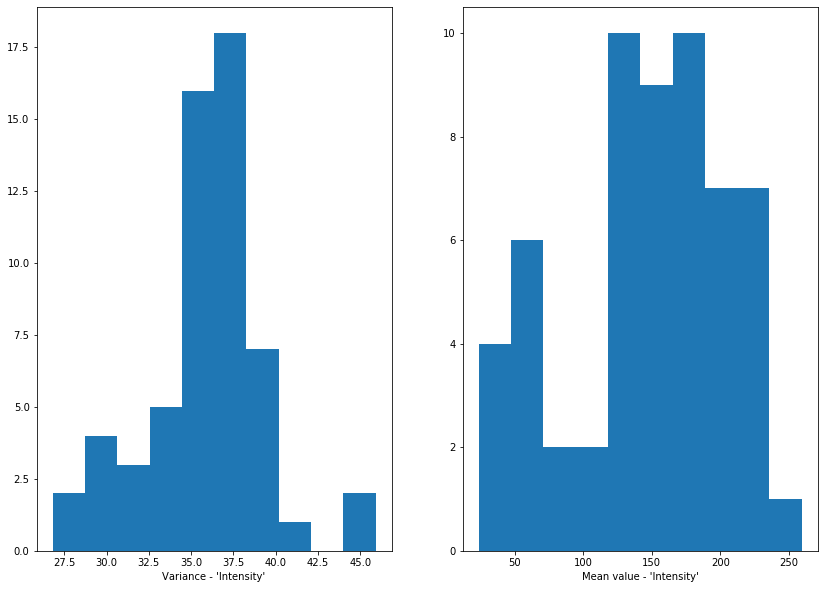

In [9]:
#Label, get_center, take from each center point, a radius of half the actual radius of that region, mask the array to exclude the rest
# for that blob, then get the average deviation of intensity for each of the remaining blob surfaces.
print(roughs, len(roughs))
fig, ax = plt.subplots(ncols=2, figsize=(14,10))
ax[0].hist(roughs)
ax[0].set_xlabel("Variance - 'Intensity'")
ax[1].hist(means)
ax[1].set_xlabel("Mean value - 'Intensity'")

Text(0, 0.5, 'Frequency')

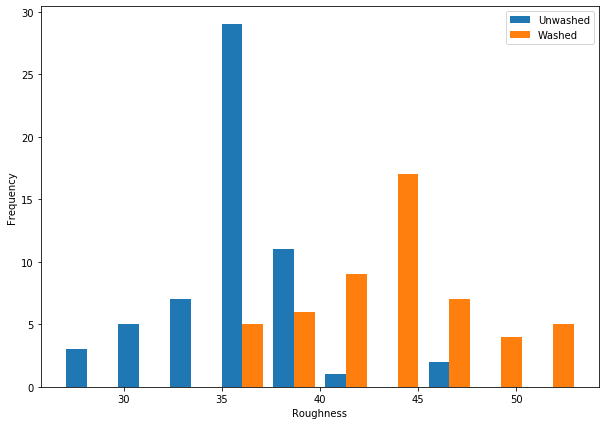

In [10]:
fig, ax = plt.subplots(figsize=(10,7))
ax.hist((roughs, wroughs), label = ("Unwashed", "Washed"))
ax.legend(prop={'size': 10})
ax.set_xlabel("Roughness")
ax.set_ylabel("Frequency")